# Customer Behavioral Segmentation

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
import warnings

In [2]:
# Turn off warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## I. Data input

In [3]:
# Import data
df=pd.read_csv('customer_data.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


## II. Data Exploration

In [4]:
# Basic data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
# Check missing values
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

We have 29 features and 2240 records

**From the above output, we can conclude and note that:**

- There are missing values in income
- Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime

In [6]:
# Convert Dt_Customer to datetime type
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

Because the number of missing values ​​is too small compared to the entire data set, we will delete the rows containing missing values.

In [7]:
# Drop NA values
df.dropna(inplace=True)

In [8]:
# Check categorical columns
cat_cols=df.select_dtypes(include='object')
cat_cols.columns

Index(['Education', 'Marital_Status'], dtype='object')

In [9]:
for i in cat_cols.columns:
    print(f'Number of categories of {i}:\n', cat_cols[i].value_counts())

Number of categories of Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64
Number of categories of Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


We see that each category column has many different values. To simplify the data, we will group related values ​​together and create a new group of values.

**Next I will create some additional columns needed from the original data:**
- Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person. I will choose the max year in Dt_Customer as the date reference point
- Create feature "Total_Spent" indicating the total amount spent by the customer in various categories.
- Combine similar values ​​in "Marital_Status" and "Education" column to reduce the number of unique values
- Create a feature "Children" to indicate total children in a household that is, kids and teenagers.
- To get further clarity of household, Creating feature indicating "Family_size"y_size"

In [10]:
# Create some features
# Calculate Age of customer (using max year in Dt_Customer)
df['Age']=df['Dt_Customer'].dt.year.max()-df['Year_Birth']

# Calculate Total Amount Spent of customer on different categories
df['Total_Spent']=df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']

# Calculate Total of Children of each customer
df['Children']=df['Kidhome']+df['Teenhome']

# Segmenting education levels in three groups
df['Education']=df['Education'].replace({'Basic':'Undergraduate',
                                         '2n Cycle':'Undergraduate',
                                        'Graduation':'Graduate',
                                        'PhD':'Postgraduate',
                                        'Master':'Postgraduate'})

# Segmenting Martial Status in two groups
df['Marital_Status']=df['Marital_Status'].replace({'Married':'Partner',
                                                 'Together':'Partner',
                                                 'Single':'Alone',
                                                 'Divorced':'Alone',
                                                 'Widow':'Alone',
                                                 'Absurd':'Partner',
                                                 'YOLO':'Partner'})

# Calculate Total family members
df['Family_size']=df['Marital_Status'].replace({'Partner':2, 'Alone':1})+df['Children']

Because we have created some new features from the original columns, we will remove some unnecessary columns or columns used for calculation to avoid duplicate data in meaning, leading to correlation between features.

In [11]:
# Delete redundant columns
df=df[['Education', 'Marital_Status', 'Income', 'Recency', 'NumDealsPurchases',
      'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
      'Age', 'Total_Spent', 'Children', 'Family_size']]

In [12]:
df.describe()

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Total_Spent,Children,Family_size
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,49.012635,2.323556,4.085289,2.671029,5.800993,5.319043,45.179603,607.075361,0.947202,2.594314
std,25173.076661,28.948352,1.923716,2.740951,2.926734,3.250785,2.425359,11.985554,602.900476,0.749062,0.904538
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,5.000000,0.000000,1.000000
25%,35303.000000,24.000000,1.000000,2.000000,0.000000,3.000000,3.000000,37.000000,69.000000,0.000000,2.000000
50%,51381.500000,49.000000,2.000000,4.000000,2.000000,5.000000,6.000000,44.000000,396.500000,1.000000,3.000000
75%,68522.000000,74.000000,3.000000,6.000000,4.000000,8.000000,7.000000,55.000000,1048.000000,1.000000,3.000000
max,666666.000000,99.000000,15.000000,27.000000,28.000000,13.000000,20.000000,121.000000,2525.000000,3.000000,5.000000


We can see that there is an unreasonable difference between the average value and the maximum value in the Income and Age columns. Obviously, the average of the Income column is just over 52k, but the maximum value is up to 666666, which shows that the Income column has an outlier value. The same goes for the Age column, we see that the oldest customer is 121 years old, which is quite rare.

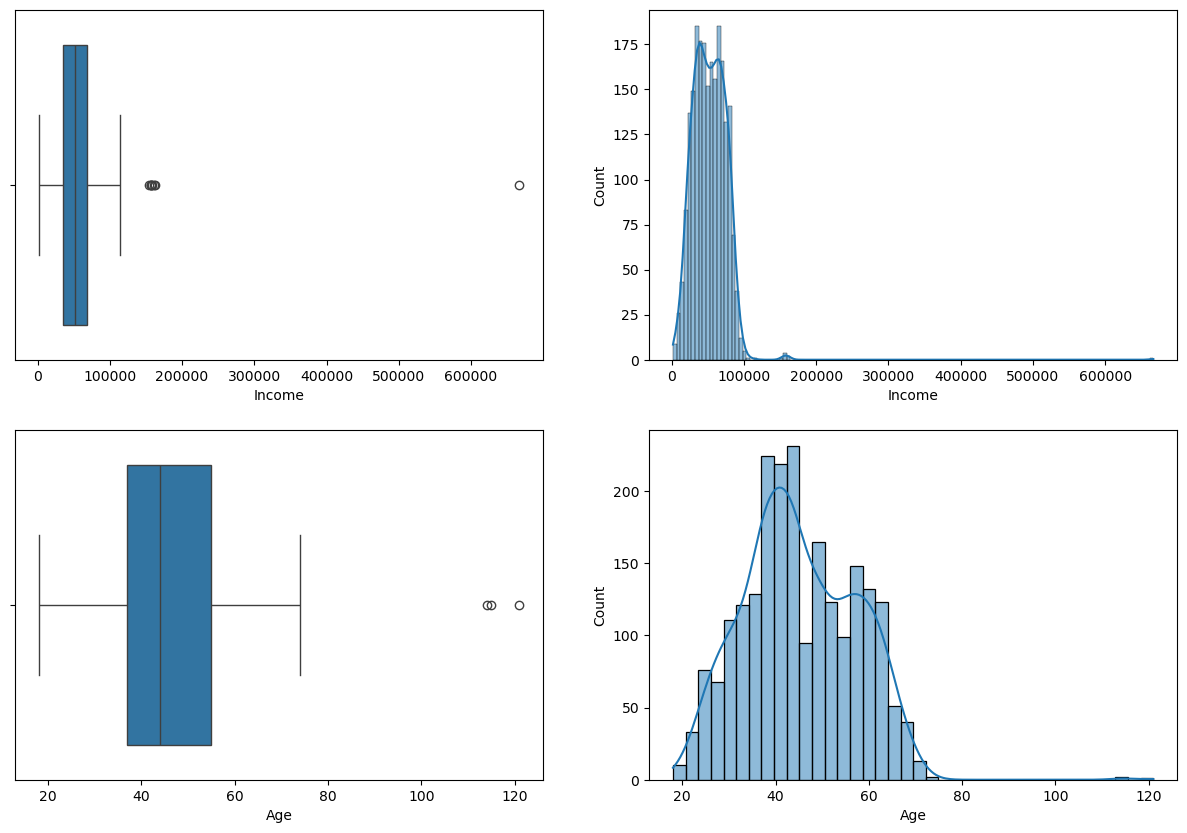

In [13]:
# Check outliers in Income and Age columns
fig, ax=plt.subplots(2,2, figsize=(15,10))
ax1=sns.boxplot(data=df, x='Income', ax=ax[0,0])
ax2=sns.histplot(data=df, x='Income', kde=True, ax=ax[0,1])
ax3=sns.boxplot(data=df, x='Age', ax=ax[1,0])
ax4=sns.histplot(data=df, x='Age', kde=True, ax=ax[1,1])

Through the chart above, the 2 columns are having a skewed distribution due to the presence of a few outliers. With the Income column, there is only 1 value greater than 600k, the rest still have some outliers but do not affect the distribution of the column too much. Similarly, with the Age column, there are about 3 values ​​greater than 100, this will skew the distribution of the data.

And because the number of outliers is quite small, we will simply delete them.

In [14]:
# Delete outliers
df=df[df['Income']<200000]
df=df[df['Age']<100]

## Data Preprocessing

**In this section, I will be preprocessing the data to perform clustering operations:**

- Because we have 2 columns of category data type, we will encode those 2 columns with Label Encoder
- Check for correlation matrix
- Scaling the features with Standard Scaler

In [15]:
# Encoding categorial data
from sklearn.preprocessing import LabelEncoder

data=df.copy() # Create a copy of the data for preprocessing and clustering
le=LabelEncoder()
data['Education']=le.fit_transform(data['Education'])
data['Marital_Status']=le.fit_transform(data['Marital_Status'])

<Axes: >

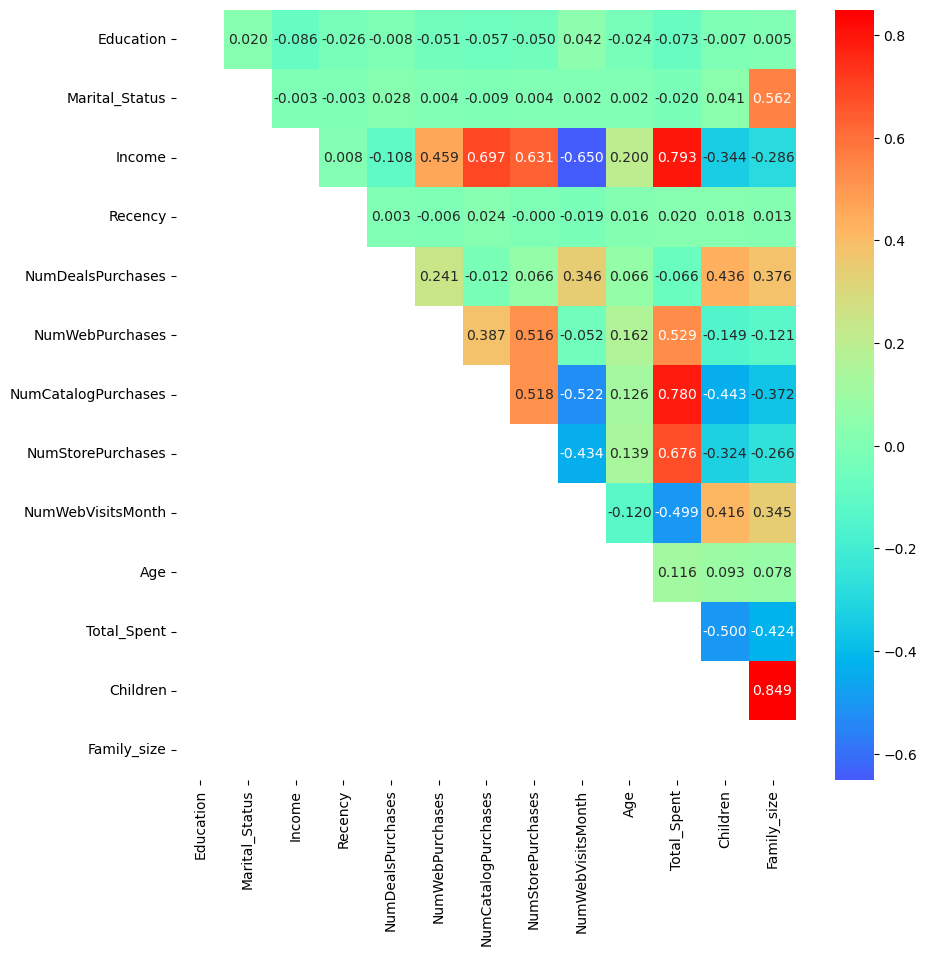

In [16]:
# Correlation Matrix
corr=data.corr()
mask=np.tril(corr)
plt.figure(figsize=(10,10))  
sns.heatmap(corr,annot=True, mask=mask, cmap='rainbow', center=0, fmt='.3f')

In [17]:
# Scaling data
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
data_scale=scaler.fit_transform(data)
data_scale=pd.DataFrame(data=data_scale, columns=data.columns)
data_scale.head()

,Education,Marital_Status,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Total_Spent,Children,Family_size
0,-0.893586,-1.354953,0.287105,0.310353,0.351030,1.426865,2.503607,-0.555814,0.692181,1.018352,1.676245,-1.264598,-1.762663
1,-0.893586,-1.354953,-0.260882,-0.380813,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,1.274785,-0.963297,1.404572,0.447660
2,-0.893586,0.738033,0.913196,-0.795514,-0.688432,1.426865,-0.229679,1.290224,-0.544908,0.334530,0.280110,-1.264598,-0.657501
3,-0.893586,0.738033,-1.176114,-0.795514,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.289547,-0.920135,0.069987,0.447660
4,0.571657,0.738033,0.294307,1.554453,1.390492,0.332600,0.111982,0.059532,-0.132545,-1.033114,-0.307562,0.069987,0.447660


Because the data for clustering includes many characteristics or features, the more features, the more difficult the model is to perform. Therefore, to make clustering easier and the model faster, we will perform the data dimensionality reduction step before performing clustering.

*Dimensionality reduction is a method for representing a given dataset using a lower number of features while still capturing the original data’s meaningful properties. This amounts to removing irrelevant or redundant features, or simply noisy data, to create a model with a lower number of variables.*

The issue here is how many features or components after reducction to ensure that the most information is retained.

There are two common ways to choose the number of components: 'Cumulative Explained Variance' and 'Scree Plot'. With the first method, we will choose the number of components so that the total cumulative explained variance is at least 90%. With the second method, we will find the break point at which increasing the number of components does not increase the cumulative explained variance.

In this project we will implement both methods.

''

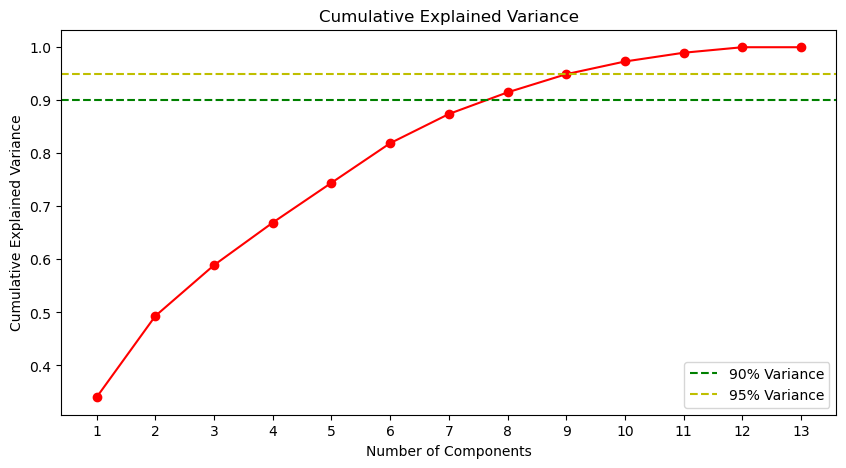

In [18]:
# Choosing number of components for PCA
from sklearn.decomposition import PCA

pca=PCA()
pca.fit(data_scale)

explained_variance_ratio=pca.explained_variance_ratio_
cumulative_variance=np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='r')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='y', linestyle='--', label='95% Variance')
plt.legend(loc='best')
plt.xticks(range(1, len(cumulative_variance) + 1))
;

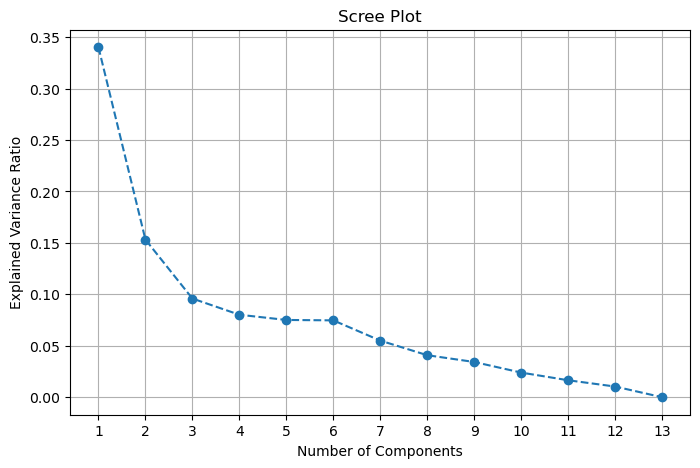

In [19]:
# Using Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.title('Scree Plot')
plt.grid(True)

Based on the 2 charts corresponding to the 2 methods, we see that each method will produce a different number of components. With the Cumulative Explained Variance method, the minimum number of components is 8, while the Scree plot only needs 3. We will perform clustering with both data sets above, then based on the clustering evaluation indexes to find the appropriate data method.

In [20]:
# Choose n_components=8 based on Cumulative Explained Variance

pca1=PCA(n_components=8)
pca_data1=pca1.fit_transform(data_scale)

pca_df1=pd.DataFrame(data=pca_data1)

# Choose n_components=3 based on Scree Plot
pca2=PCA(n_components=3)
pca_data2=pca2.fit_transform(data_scale)
pca_df2=pd.DataFrame(data=pca_data2)

In [21]:
# Clustering

# Find number of clusters using Elbow
# For 8 components
from sklearn.cluster import KMeans
sse1={}
for k in range(1,11):
    kmeans=KMeans(n_clusters=k, random_state=10)
    kmeans.fit(pca_df1)
    sse1[k]=kmeans.inertia_

sse2={}
for k in range(1,11):
    kmeans=KMeans(n_clusters=k, random_state=10)
    kmeans.fit(pca_df2)
    sse2[k]=kmeans.inertia_

''

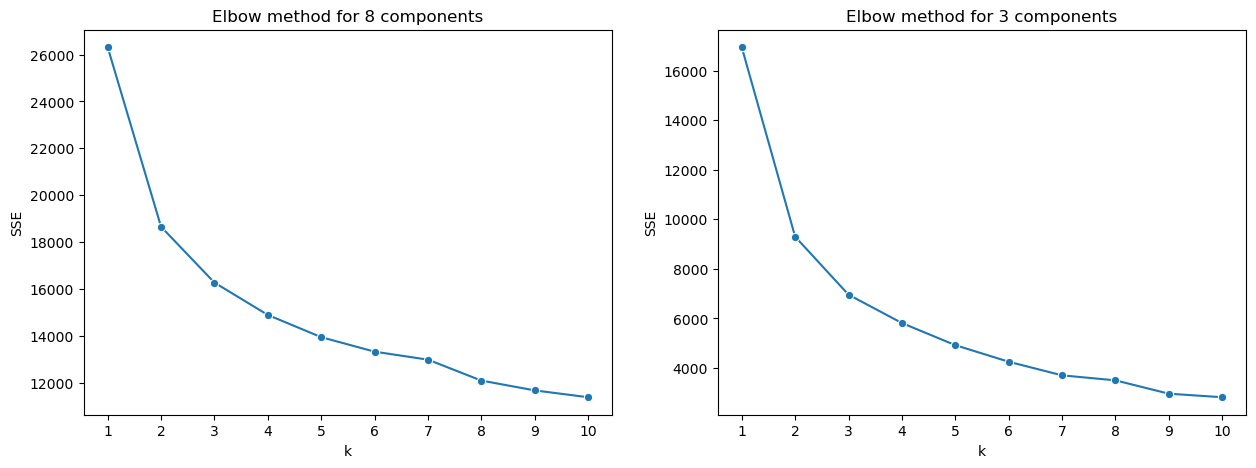

In [22]:
fig, ax=plt.subplots(1,2, figsize=(15,5))
sns.lineplot(x=list(sse1.keys()), y=list(sse1.values()), marker='o', ax=ax[0])
sns.lineplot(x=list(sse2.keys()), y=list(sse2.values()), marker='o', ax=ax[1])
ax[0].set_title('Elbow method for 8 components')
ax[1].set_title('Elbow method for 3 components')
ax[0].set_xlabel('k')
ax[0].set_ylabel('SSE')
ax[0].set_xticks(range(1,11))
ax[1].set_xlabel('k')
ax[1].set_ylabel('SSE')
ax[1].set_xticks(range(1,11))
;

In [23]:
# Choose k=3
kmeans=KMeans(n_clusters=3, random_state=1)
segment1=kmeans.fit_predict(pca_df1)
segment2=kmeans.fit_predict(pca_df2)

Clustering evaluation is not as trivial as counting the number of errors or the precision and recalls like supervised learning algorithms. So, cluster validation is based on similarity or dissimilarity measures, such as the distance between cluster points. If the clustering algorithm separates dissimilar observations apart and similar observations together, then it has performed well. The two most popular evaluation metrics for clustering algorithms are the Silhouette coefficient and Davies-Bouldin Score.

- The Silhouette Coefficient takes into account the distances within and between the clusters. The Silhouette values lie in the [-1,1] interval, with -1 indicating mislabeling, 0 indicating cluster overlap, and 1 indicating the perfect score. Values ​​close to 1 indicate that points in the same cluster are close to each other and far away from other clusters.
- The Davies-Bouldin Score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score. 
The minimum score is zero, with lower values indicating better clustering

In [24]:
# Evaluate Clustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette1=silhouette_score(pca_df1, segment1)
davies_bouldin1=davies_bouldin_score(pca_df1, segment1)

silhouette2=silhouette_score(pca_df2, segment2)
davies_bouldin2=davies_bouldin_score(pca_df2, segment2)

result={'8 Components':[silhouette1, davies_bouldin1],
       '3 Components':[silhouette2, davies_bouldin2]}
result_df=pd.DataFrame(data=result, index=['Silhouette Coefficient', 'Davies-Bouldin Score'])
result_df

,8 Components,3 Components
Silhouette Coefficient,0.194174,0.367952
Davies-Bouldin Score,1.820777,1.074668


With the above results, 3 components will give better results than 8 components.

In [25]:
df['Segment']=segment2
data['Segment']=segment2

## Model Evaluating

Since this is an unsupervised clustering. We do not have a targged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

**Firstly, let us have a look at the group distribution of clustring**

''

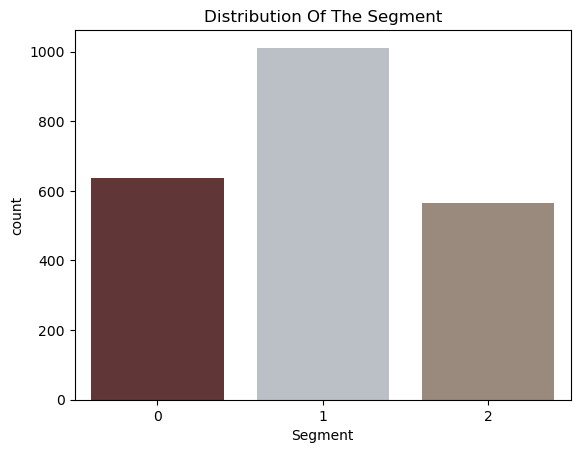

In [26]:
# Visualizing result
pal = ["#682F2F","#B9C0C9", "#9F8A78"]
ax=sns.countplot(data=df, x='Segment', palette= pal)
ax.set_title("Distribution Of The Segment")
;

The clusters seem to be fairly distributed.

''

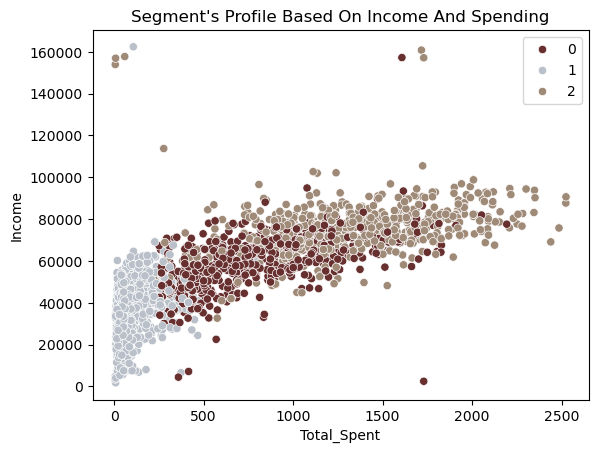

In [27]:
sns.scatterplot(data=df,x='Total_Spent', y='Income',hue='Segment', palette= pal)
plt.title("Segment's Profile Based On Income And Spending")
plt.legend()
;

**From the above results we can see a clear segmentation between Income and Total_Spent.**

- Group 1 is mainly people with relatively low Income and very low Spending
- 
Group 0 has averageSpendingn andIncome
- 
Group 2 belongs to people with averagIncomeme but very higSpending

**So I will name the groups as follows:**

- Group 0: Average Income & Spent
- Group 1: Low Income & Spent
- Group 2: Average Income & High Spenton

In [28]:
# Rename Segments
df['Segment']=df['Segment'].replace(0, 'Average Income & Spent')
df['Segment']=df['Segment'].replace(1, 'Low Income & Spent')
df['Segment']=df['Segment'].replace(2, 'Average Income & High Spent')

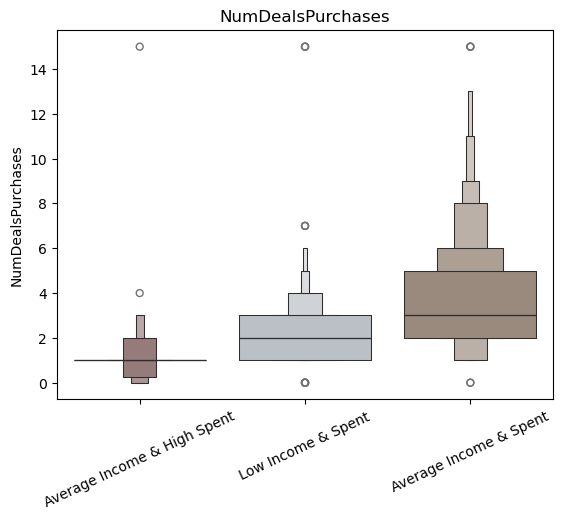

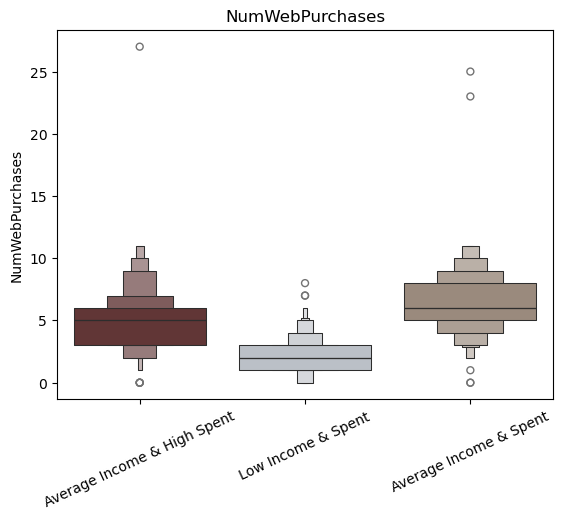

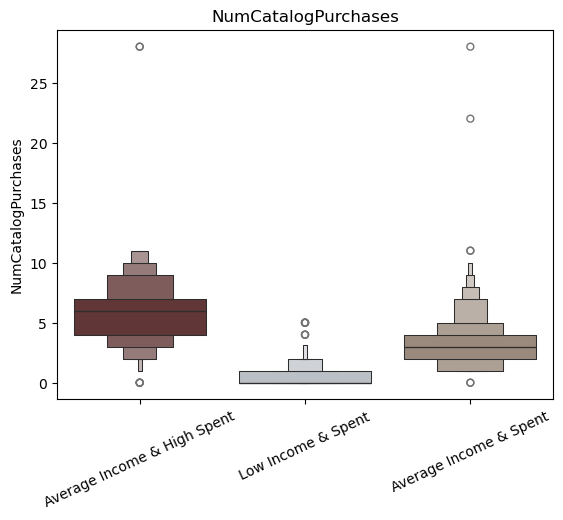

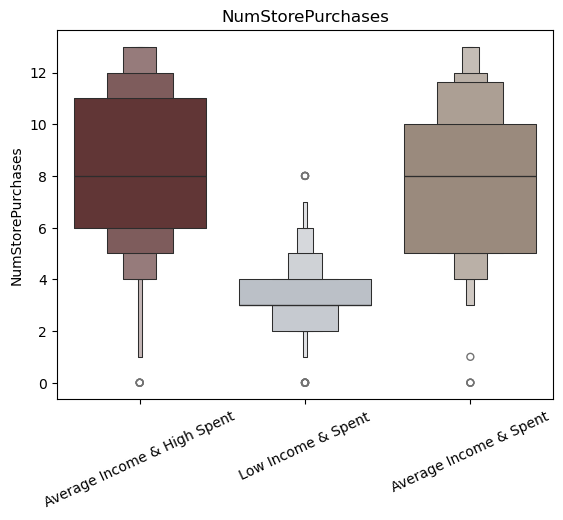

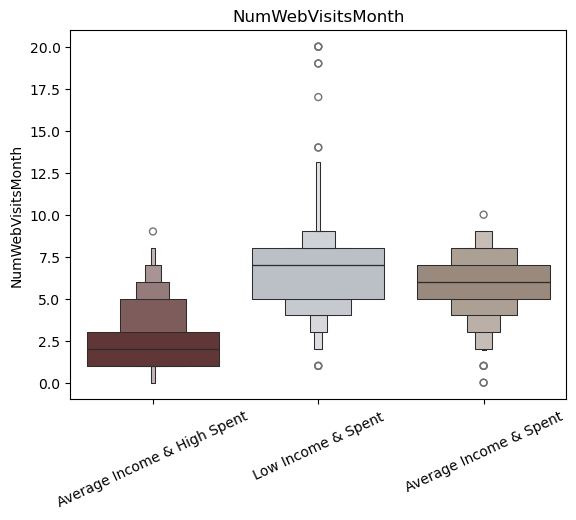

In [29]:
columns=['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases','NumWebVisitsMonth']
for col in columns:
    sns.boxenplot(data=df, x='Segment', y=col, palette= pal)
    plt.title(col)
    plt.xticks(rotation=25)
    plt.xlabel(None)
    plt.show()

The above results describe the purchasing behavior of each segment through the following aspects: 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'. The results show that:
- With the Average Income & High Spent segment, the number of times they buy with Discount is very small, they tend to buy at the store rather than through the Website or Catalog.
- With the Average Income & Spent segment, it is quite similar to the above segment, the only difference is that they buy a lot with Discount.
- With the last segment, because they are low-income people, they mainly only go to the Website to view products, only a few people can buy and they also mainly buy with Discount.

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8336\2165828540.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8336\2165828540.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8336\2165828540.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)


''

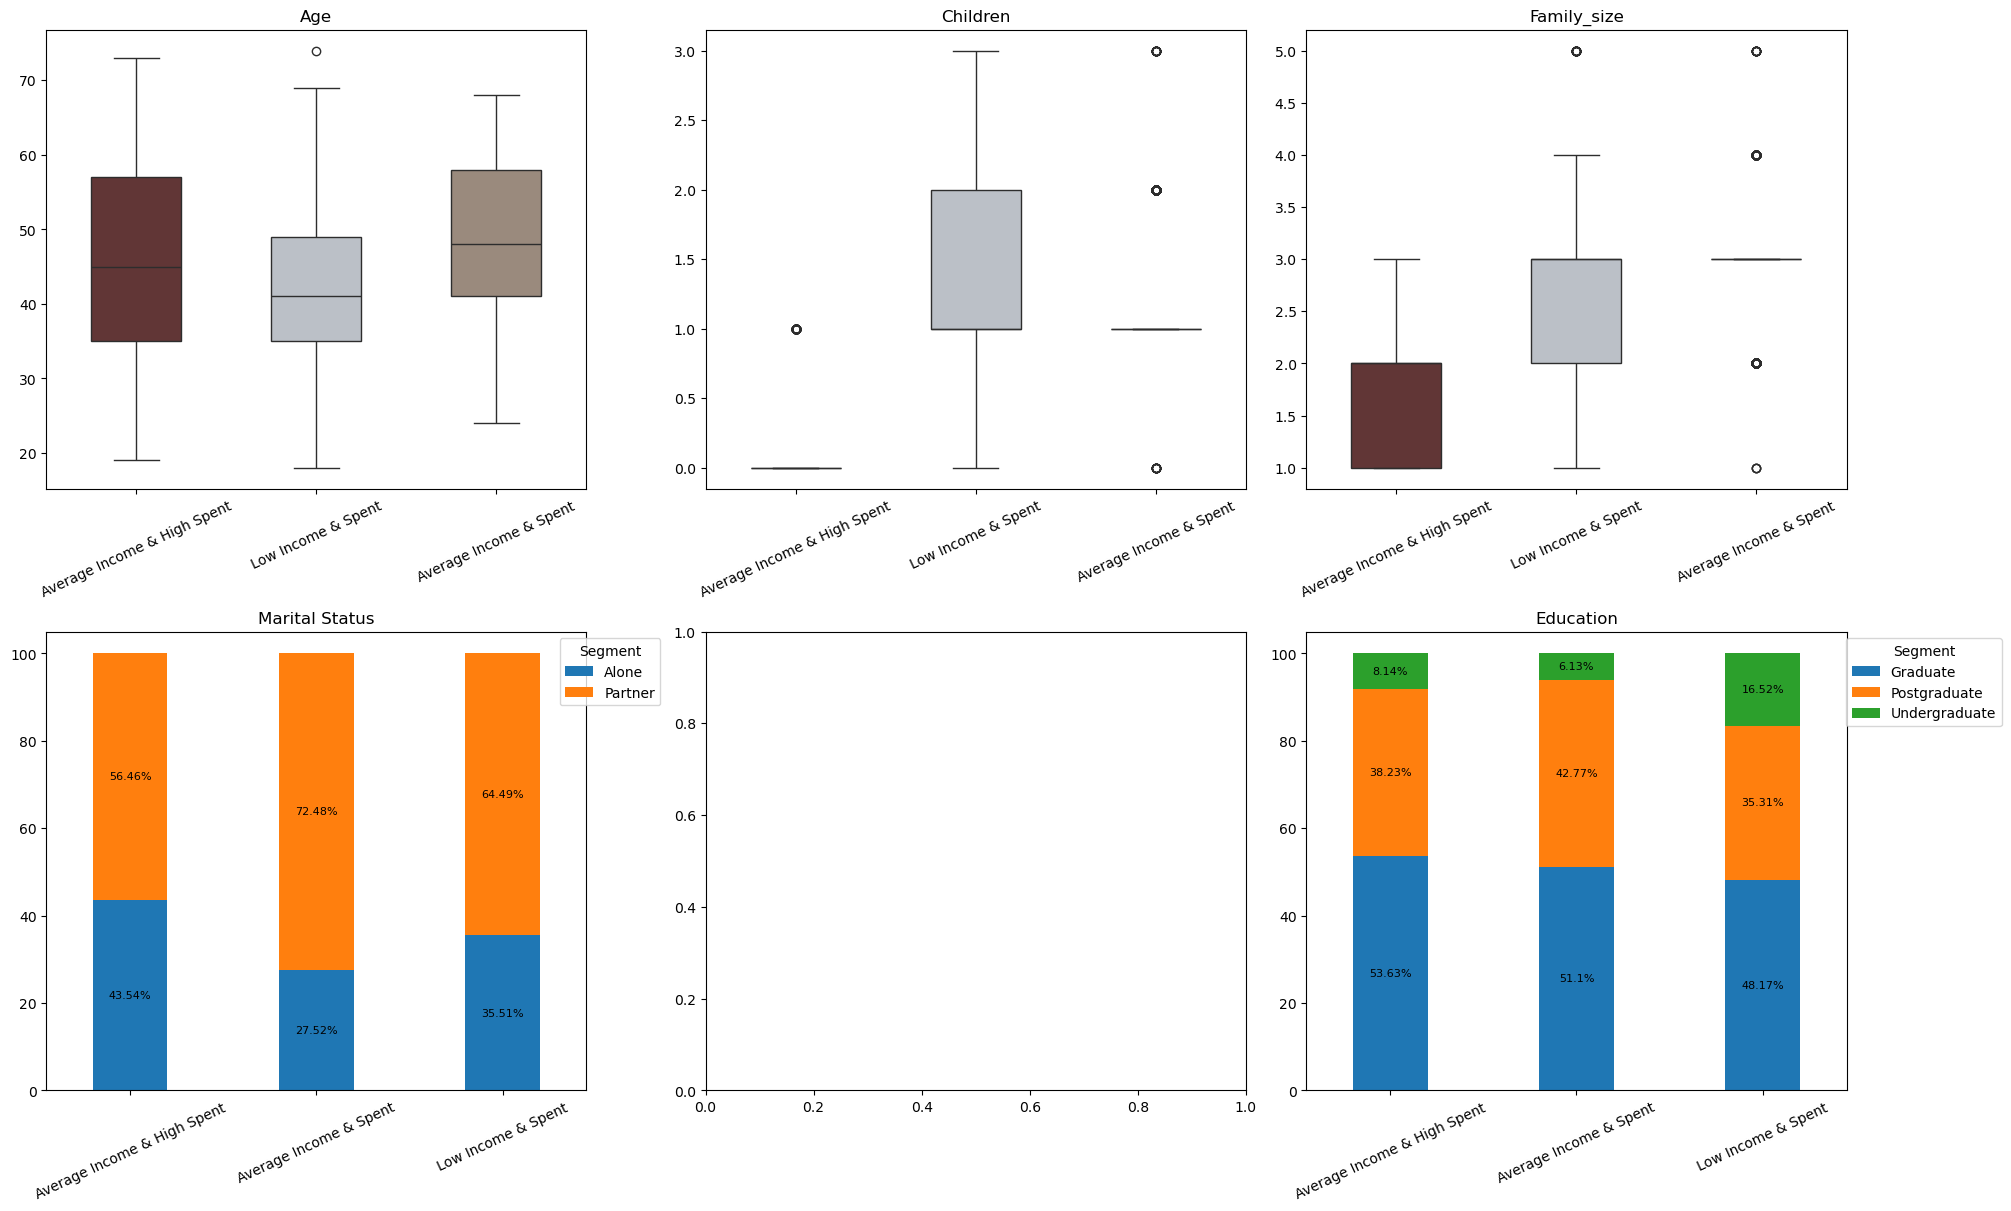

In [30]:
# Customer profiling
df_education=df.groupby('Segment')['Education'].value_counts(normalize=True).mul(100).round(2).unstack()
df_marital_status=df.groupby('Segment')['Marital_Status'].value_counts(normalize=True).mul(100).round(2).unstack()

fig, ax=plt.subplots(2,3, figsize=(20,12), constrained_layout=True)
for i, col in enumerate(df[['Age', 'Children', 'Family_size']].columns):
    sns.boxplot(data=df, x='Segment', y=col, width=0.5, ax=ax[0,i], palette=pal)
    ax[0,i].set_title(col)
    ax[0,i].set_xlabel(None)
    ax[0,i].set_ylabel(None)
    ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)

ax1=df_marital_status.plot(kind='bar', stacked=True, width=0.4, ax=ax[1,0])
for c in ax1.containers:
    labels=[str(round(v.get_height(), 2)) + '%' if v.get_height() >0 else '' for v in c]
    ax1.bar_label(c, label_type='center', labels=labels, size=8)
ax1.legend(loc='upper right', bbox_to_anchor=(1.15,1), title='Segment')
ax1.set_title('Marital Status')
ax1.set_xlabel(None)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=25)

ax2=df_education.plot(kind='bar', stacked=True, width=0.4, ax=ax[1,2])
for c in ax2.containers:
    labels=[str(round(v.get_height(), 2)) + '%' if v.get_height() >0 else '' for v in c]
    ax2.bar_label(c, label_type='center', labels=labels, size=8)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3,1), title='Segment')
ax2.set_title('Education')
ax2.set_xlabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25)
;

**We can describe the characteristics of each customer segment:**
- *Average Income & High Spent:* They are usually middle-aged people (over 30), mostly couples but most of them do not have children (maybe because they are not married), families mainly have only 1-2 people (maybe the family has children but the parents are divorced)
- *Low Income & Spent:* They are usually younger than the above segment (under 50 years old), almost all have at least 1 child, and most of them are married, so the number of family members is mostly at least 2.
- *Average Income & Spent:* They are usually older than the previous 2 groups (over 40 years old), almost all have only 1 child and most of them are couples (maybe married), so the number of family members is mainly 3 people.

C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


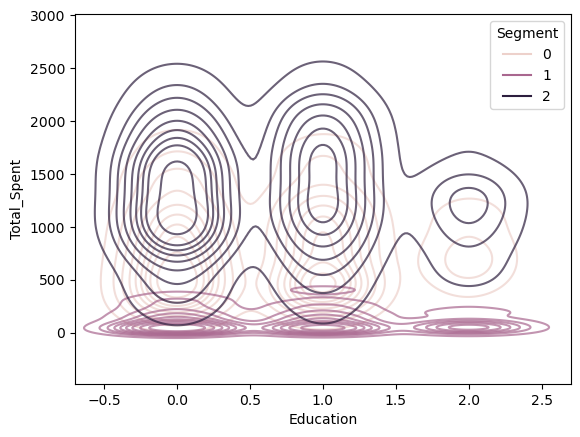

C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


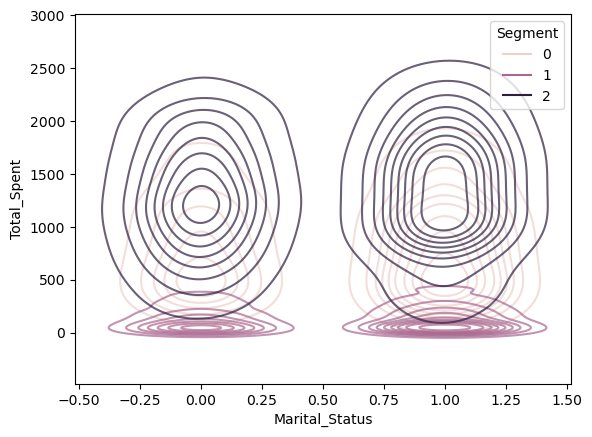

C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


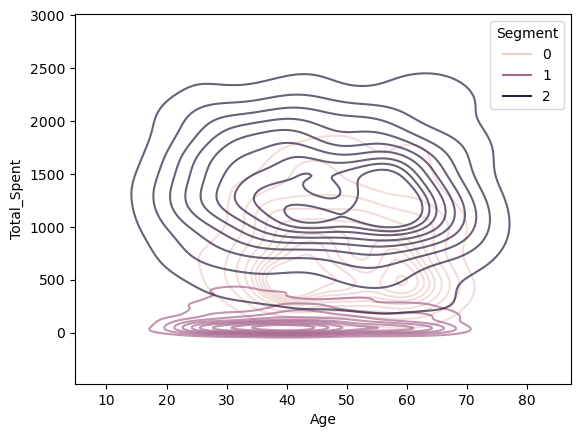

C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


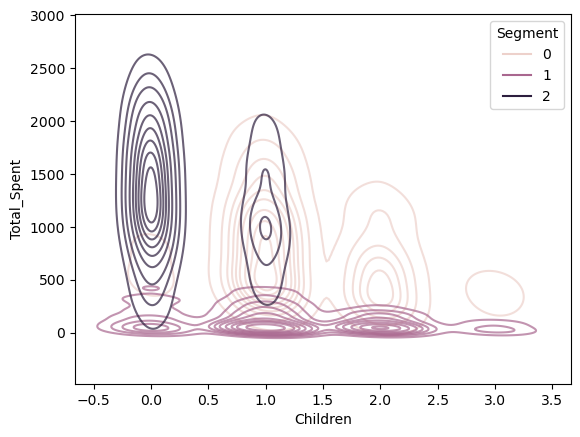

C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


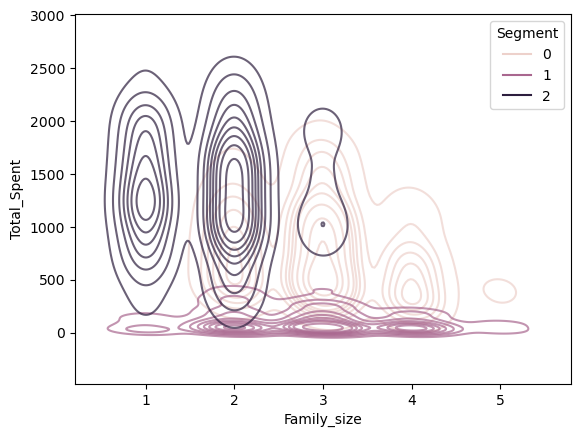

In [31]:
personal=['Education', 'Marital_Status', 'Age', 'Children', 'Family_size']
for col in personal:
    sns.kdeplot(
        data=data, x=col, y="Total_Spent", hue="Segment", 
        fill=False, common_norm=False, 
        alpha=0.7, linewidth=2)
    plt.show()
    ;

# End!